# Solving the maximum margin problem with quadratic programming (QP) and the RBF kernel

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data forming a well separated annulus.


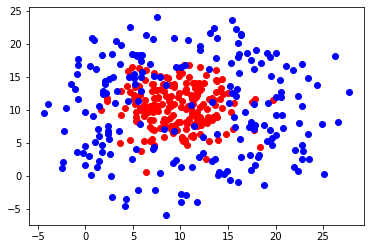

In [8]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 200

mu = np.array([10, 10])
sigma = np.array([[10, 0], [0, 10]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 3
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.show()


In [9]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((m_per_class, 1)), np.ones((m_per_class, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


In [10]:

# Kernels

def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
            
# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

m = X.shape[0]
rbf_sigma = 2
C = 3
c = - np.ones((m, 1))
Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
A = np.concatenate((-np.eye(m), np.eye(m)), 0)
b = np.concatenate((np.zeros((m, 1)), np.ones((m, 1)) * C), 0)
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -1.9866e+02 -3.0461e+03  7e+03  8e-01  4e-15
 1: -1.6588e+02 -9.5811e+02  8e+02  4e-15  5e-15
 2: -2.5178e+02 -4.4637e+02  2e+02  2e-14  5e-15
 3: -2.8149e+02 -3.4178e+02  6e+01  3e-14  5e-15
 4: -2.9156e+02 -3.0967e+02  2e+01  1e-14  5e-15
 5: -2.9507e+02 -3.0062e+02  6e+00  1e-14  5e-15
 6: -2.9623e+02 -2.9764e+02  1e+00  2e-14  5e-15
 7: -2.9650e+02 -2.9707e+02  6e-01  5e-14  5e-15
 8: -2.9663e+02 -2.9682e+02  2e-01  1e-13  5e-15
 9: -2.9669e+02 -2.9672e+02  4e-02  2e-14  5e-15
10: -2.9670e+02 -2.9670e+02  1e-03  5e-14  5e-15
11: -2.9670e+02 -2.9670e+02  2e-05  3e-14  5e-15
Optimal solution found.


In [11]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [2.01528313e+00 1.51944181e+00 2.99999999e+00 2.99999989e+00
 2.93394450e+00 2.99999996e+00 2.66247916e+00 2.99999997e+00
 2.99999996e+00 4.90983996e-01 2.99999997e+00 2.99999965e+00
 1.88817380e+00 1.13316611e-01 2.99999999e+00 2.99999994e+00
 2.71115413e+00 2.99999998e+00 2.99999999e+00 2.99999997e+00
 2.99999974e+00 2.50002827e+00 3.44971339e-01 2.99999997e+00
 2.99999998e+00 2.99999997e+00 2.99999998e+00 2.24232059e+00
 2.99999991e+00 2.73405644e+00 2.99999998e+00 8.34557963e-01
 2.99999993e+00 2.99999998e+00 2.99999901e+00 2.99999997e+00
 2.99999991e+00 9.77754180e-01 1.89031692e+00 2.07584829e+00
 4.39240893e-01 2.00652112e-01 2.99999999e+00 2.99999999e+00
 2.12518106e-05 2.99999998e+00 2.99999998e+00 2.27958016e+00
 2.99999993e+00 2.99999997e+00 2.42160316e+00 1.11632626e+00
 5.97056115e-01 7.13027473e-02 2.53520135e-01 2.99999999e+00
 1.21304521e-01 9.03385375e-04 2.99999998e+00 2.99999983e+00
 2.99999997e+00 2.99999999e+00 1.58187147e-05 1.81950986e+0

array([4.59620776e-05])

In [12]:
# How to perform inference with a kernel rather than w,b?

def b_from_alpha(X, y, alpha, rbf_sigma):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    b = (y_s - ((alpha_s * y_s).T * rbf_kernel(X_s, rbf_sigma)).sum(axis=1, keepdims=True)).mean()
    return b

def rbf_kernel_1(x, xprime, rbf_sigma):
    return np.exp(- (x - xprime) @ (x - xprime) / 2 / rbf_sigma / rbf_sigma)
    
def svm_predict(x, X, y, alpha, rbf_sigma):
    b = b_from_alpha(X, y, alpha, rbf_sigma)
    results = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        results[i] = 0
        for j in range(X.shape[0]):
            results[i, 0] += alpha[j] * y[j, 0] * rbf_kernel_1(x[i,:], X[j,:], rbf_sigma)
        results[i] += b
    return np.sign(results)

# svm_predict(np.array([[10, 10], [20, 20]]), X, y, opt_params, rbf_sigma)

In [13]:
train_pred = svm_predict(X, X, y, opt_params, rbf_sigma)
accuracy = (train_pred == y).mean()
print('Training accuracy:', accuracy)

Training accuracy: 0.9


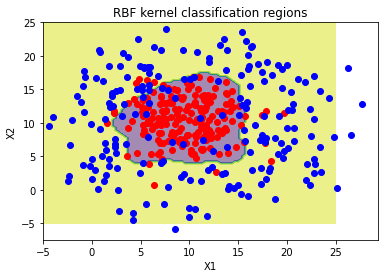

In [16]:

# Blue margin line

# x21 = (-w[0] * x11 - b + 1) / w[1]
# x22 = (-w[0] * x12 - b + 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

# Red margin line

# x21 = (-w[0] * x11 - b - 1) / w[1]
# x22 = (-w[0] * x12 - b - 1) / w[1]

# plt.plot((x11, x12), (x21, x22), 'k-')

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

# Overlay colored regions according to svm_predict

grid_x, grid_y = np.mgrid[-5:25:100j, -5:25:100j]
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
grid_z = svm_predict(grid_xy, X, y, opt_params, rbf_sigma).reshape((100, 100))

plt.contourf(grid_x, grid_y, grid_z, alpha=0.5)

plt.title('RBF kernel classification regions')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()